In [49]:
# 运行此段做数据准备
import cv2
import numpy as np
import matplotlib.pyplot as plt

srcImg = cv2.imread('../images/flower.png', 0)
rows, cols = srcImg.shape

In [50]:
'''
# 运动模糊
'''

# 定义运动方向和距离
angle = 45
distance = 10
# 计算运动矩阵
motion_mat = cv2.getRotationMatrix2D((distance, distance), angle, 1)


# 应用运动矩阵,kernel_size取决于distance，这决定了我们将多少像素叠加在一起
# 卷积核将运动方向上的像素叠加后取平均，运动方向的的像素由插值法取得
kernel_size = (distance, distance)
motion_blur_kernel = np.zeros(kernel_size)
# 先假设运动模糊在水平方向
motion_blur_kernel[int(distance // 2), :] = np.ones(distance)
# 值得注意的是这里cv2.warpAffine输入参数dsize=kernel_size，严格意义上输入应该是kernel_size的倒序
motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, motion_mat, dsize = kernel_size)
motion_blur_kernel = motion_blur_kernel / distance
# 此处确保卷积核权值和为1，小于或大于1时会使图片偏暗或偏亮
motion_blur_kernel = motion_blur_kernel / np.sum(motion_blur_kernel)
img_motion_blur = cv2.filter2D(srcImg, -1, motion_blur_kernel)

# 为图像添加恒功率噪声
# 定义噪声均值和标准差，高斯白噪声的平均功率等于方差
mean = 0
sigma = 50
noise = np.zeros(srcImg.shape, np.uint8)
noise = cv2.randn(noise, mean, sigma)
img_noisy = cv2.add(img_motion_blur, noise)

# # 显示图像
# cv2.imshow('Image', srcImg)
# cv2.imshow('Motion Blur', img_motion_blur)
# cv2.imshow('Add Gaussian Noise based on Motion Blur', img_noisy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


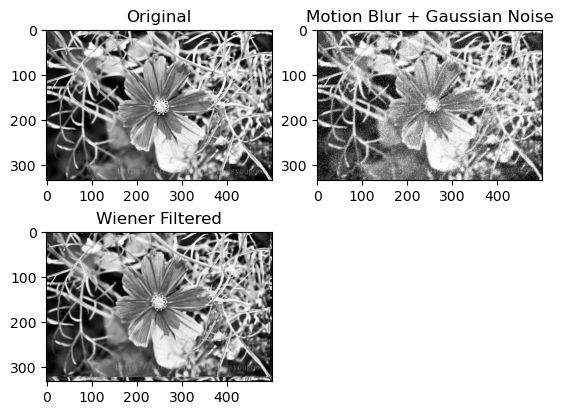

In [51]:
'''
# 维纳滤波
'''
def wiener_filter(image, kernel, K):
    # 计算傅里叶变换
    image_fft = np.fft.fft2(image)
    kernel_fft = np.fft.fft2(kernel, s=image.shape)
    
    # 计算维纳滤波器的频域表示
    H = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K)
    
    # 应用维纳滤波器
    filtered_image_fft = image_fft * H
    
    # 反傅里叶变换得到滤波后的图像
    filtered_image = np.fft.ifft2(filtered_image_fft)
    filtered_image = np.abs(filtered_image)
    
    # 将图像像素值限制在0到255之间
    filtered_image = np.clip(filtered_image, 0, 255)
    filtered_image = filtered_image.astype(np.uint8)
    
    return filtered_image

# 设置维纳滤波器参数
K = 0.02



# 对运模糊图像进行维纳滤波
filtered_image = wiener_filter(img_motion_blur, motion_blur_kernel, K)

# 显示图像
plt.subplot(221), plt.imshow(srcImg, cmap='gray'), plt.title('Original')
plt.subplot(222), plt.imshow(img_noisy, cmap='gray'), plt.title('Motion Blur + Gaussian Noise')
plt.subplot(223), plt.imshow(filtered_image, cmap='gray'), plt.title('Wiener Filtered')
plt.show()

cv2.imshow('Image', srcImg)
cv2.imshow('Add Gaussian Noise based on Motion Blur', img_noisy)
cv2.imshow('wiener_filter', filtered_image)

cv2.waitKey(0)
cv2.destroyAllWindows()